In [1]:
!unzip /content/DataDrivenAcceleration-XJ.zip -d /content/DataDrivenAcceleration-XJ
!pip install pydoe

%cd /content/DataDrivenAcceleration-XJ

unzip:  cannot find or open /content/DataDrivenAcceleration-XJ.zip, /content/DataDrivenAcceleration-XJ.zip.zip or /content/DataDrivenAcceleration-XJ.zip.ZIP.
[Errno 2] No such file or directory: '/content/DataDrivenAcceleration-XJ'
/Users/7ml/Documents/NSF-MSGI/XingjianLi_work/DataDrivenAcceleration


In [2]:
import torch
import torch.optim as optim

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io
import argparse


from src.NN_models import *
from src.pinns_burgers_model import *
from src.plotter import *
from src.anderson_acceleration import *
import AADL as AADL

## Data Prep

In [3]:
# Data Prep
data = scipy.io.loadmat('/Users/7ml/Documents/NSF-MSGI/XingjianLi_work/DataDrivenAcceleration/Data/burgers_shock_mu_01_pi.mat')
x = data['x']                                   # 256 points between -1 and 1 [256x1]
t = data['t']                                   # 100 time points between 0 and 1 [100x1]
usol = data['usol']                             # solution of 256x100 grid points

X, T = np.meshgrid(x,t)

# test data
X_u_test = np.hstack((X.flatten()[:,None], T.flatten()[:,None])); X_u_test = torch.from_numpy(X_u_test)
# Domain bounds
lb = X_u_test[0]  # [-1. 0.]
ub = X_u_test[-1] # [1.  0.99]
u_true = usol.flatten('F')[:,None]; u = torch.from_numpy(u_true)

def trainingdata(N_u,N_f):

    '''Boundary Conditions'''

    #Initial Condition -1 =< x =<1 and t = 0
    leftedge_x = np.hstack((X[0,:][:,None], T[0,:][:,None])) #L1
    leftedge_u = usol[:,0][:,None]

    #Boundary Condition x = -1 and 0 =< t =<1
    bottomedge_x = np.hstack((X[:,0][:,None], T[:,0][:,None])) #L2
    bottomedge_u = usol[-1,:][:,None]

    #Boundary Condition x = 1 and 0 =< t =<1
    topedge_x = np.hstack((X[:,-1][:,None], T[:,0][:,None])) #L3
    topedge_u = usol[0,:][:,None]

    all_X_u_train = np.vstack([leftedge_x, bottomedge_x, topedge_x]) # X_u_train [456,2] (456 = 256(L1)+100(L2)+100(L3))
    all_u_train = np.vstack([leftedge_u, bottomedge_u, topedge_u])   #corresponding u [456x1]

    #choose random N_u points for training
    idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False)

    X_u_train = all_X_u_train[idx, :] #choose indices from  set 'idx' (x,t)
    u_train = all_u_train[idx,:]      #choose corresponding u

    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points
    # N_f sets of tuples(x,t)
    X_f_train = lb + (ub-lb)*lhs(2,N_f)
    X_f_train = np.vstack((X_f_train, X_u_train)) # append training points to collocation points

    return torch.from_numpy(X_f_train).float(), torch.from_numpy(X_u_train).float(), torch.from_numpy(u_train).float()


## Training

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device: ', device)


N_u = 400
N_f = 4096
# X_f_train, X_u_train, u_train = trainingdata(N_u,N_f)
# X_f_train=X_f_train.to(device); X_u_train=X_u_train.to(device); u_train=u_train.to(device)


niters = 2000
lr = 0.01
print_freq = 50

layers = np.array([2,20,20,20,20,20,20,20,20,1]) #8 hidden layers
# net = MLP(layers); net.to(device)

# optim = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=0)
# accelerate(optim, frequency = 5)

start_time = time.time() 
print((2 * "%7s    ") % ("step", "Loss"))

# test data
X_u_test = X_u_test.to(device); u = u.to(device)

record = np.zeros((niters+1,20))
validation_err = 0.
for repeat in range(20):

    X_f_train, X_u_train, u_train = trainingdata(N_u,N_f)
    X_f_train=X_f_train.to(device); X_u_train=X_u_train.to(device); u_train=u_train.to(device)
    net = MLP(layers); net.to(device)
    idx_loss = loss_burgers(X_u_train, u_train, X_f_train, net)[0]
    record[0,repeat] = idx_loss.detach()

    optim = torch.optim.Adam(net.parameters(), lr=lr)
    # accelerate(optim, frequency = 5)
    #AADL.accelerate(optim, relaxation=1.0, store_each_nth=10, frequency=5)

    for itr in range(1, niters + 1):
        def closure():
            optim.zero_grad()
            loss, res = loss_burgers(X_u_train, u_train, X_f_train, net)
            loss.backward()
            return loss
        optim.step(closure)
        idx_loss = loss_burgers(X_u_train, u_train, X_f_train, net)[0]
        
        record[itr,repeat] = idx_loss.detach()

        # print
        if itr % print_freq == 0:
            print(("%06d    " + "%1.4e    ") %(itr, idx_loss))
        
        
        # change learning rate
        if itr % (niters/4) == 0:
            for p in optim.param_groups:
                p['lr'] *= 0.1
        

        # resample
        if itr % 500 == 0:
            X_f_train, X_u_train, u_train = trainingdata(N_u,N_f)
            X_f_train=X_f_train.to(device); X_u_train=X_u_train.to(device); u_train=u_train.to(device)
            # clear_hist(optim)

    # validation
    u_pred = net.forward(X_u_test)
    err = torch.linalg.norm((u-u_pred),2)/torch.linalg.norm(u,2)
    u_pred = u_pred.cpu().detach().numpy()
    u_pred = np.reshape(u_pred, (256, 100), order='F')
    print('Validation results, error in absolute value: ', err)
    validation_err += err


elapsed = time.time() - start_time
print('Training time: %.2f' % (elapsed))

device:  cpu
   step       Loss    
000050    1.0956e-01    
000100    7.4302e-02    
000150    6.5163e-02    
000200    5.7934e-02    
000250    6.5610e-02    
000300    5.9514e-02    
000350    8.5336e-02    
000400    5.1636e-02    
000450    1.7085e-01    
000500    6.9249e-02    
000550    6.5758e-02    
000600    6.3642e-02    
000650    6.1993e-02    
000700    6.0521e-02    
000750    5.9134e-02    
000800    5.7754e-02    
000850    5.6198e-02    
000900    5.3931e-02    
000950    5.0032e-02    
001000    4.7295e-02    
001050    4.7340e-02    
001100    4.7037e-02    
001150    4.6751e-02    
001200    4.6455e-02    
001250    4.6140e-02    
001300    4.5802e-02    
001350    4.5442e-02    
001400    4.5061e-02    
001450    4.4659e-02    
001500    4.4242e-02    
001550    4.5923e-02    
001600    4.5777e-02    
001650    4.5660e-02    
001700    4.5559e-02    
001750    4.5469e-02    
001800    4.5387e-02    
001850    4.5311e-02    
001900    4.5238e-02    
001950    4.51

000900    8.2493e-03    
000950    6.7303e-03    
001000    5.6782e-03    
001050    6.0830e-03    
001100    5.8042e-03    
001150    5.6506e-03    
001200    5.5172e-03    
001250    5.3945e-03    
001300    5.2787e-03    
001350    5.1678e-03    
001400    5.0604e-03    
001450    4.9557e-03    
001500    4.8532e-03    
001550    5.0177e-03    
001600    4.8223e-03    
001650    4.7648e-03    
001700    4.7168e-03    
001750    4.6752e-03    
001800    4.6381e-03    
001850    4.6047e-03    
001900    4.5740e-03    
001950    4.5455e-03    
002000    4.5186e-03    
Validation results, error in absolute value:  tensor(0.1739, dtype=torch.float64, grad_fn=<DivBackward0>)
000050    1.1288e-01    
000100    8.9195e-02    
000150    6.5488e-02    
000200    5.5307e-02    
000250    1.2148e-01    
000300    7.1071e-02    
000350    5.9261e-02    
000400    6.9092e-02    
000450    5.3887e-02    
000500    8.5557e-02    
000550    8.3800e-02    
000600    7.6845e-02    
000650    7.1427e-0

001850    7.4545e-03    
001900    7.4082e-03    
001950    7.3644e-03    
002000    7.3222e-03    
Validation results, error in absolute value:  tensor(0.2313, dtype=torch.float64, grad_fn=<DivBackward0>)
000050    1.0797e-01    
000100    8.1161e-02    
000150    6.1309e-02    
000200    4.7494e-02    
000250    6.5460e-02    
000300    6.4441e-02    
000350    6.2352e-02    
000400    3.2305e-02    
000450    5.8952e-02    
000500    2.8018e-02    
000550    1.5765e-02    
000600    1.2695e-02    
000650    1.1433e-02    
000700    1.0395e-02    
000750    9.5808e-03    
000800    8.9132e-03    
000850    8.3227e-03    
000900    7.7795e-03    
000950    7.2732e-03    
001000    6.8020e-03    
001050    7.3395e-03    
001100    7.1404e-03    
001150    7.0269e-03    
001200    6.9353e-03    
001250    6.8528e-03    
001300    6.7750e-03    
001350    6.7000e-03    
001400    6.6268e-03    
001450    6.5547e-03    
001500    6.4833e-03    
001550    7.3635e-03    
001600    7.2154e-0

In [ ]:
record_AADL = record

In [ ]:
# save the data
from scipy.io import savemat
# record_sgd = record
record_sgd_anderson = record

mdic = {"record_sgd_anderson": record_sgd_anderson, "label": "Burgers SGD Anderson"}
savemat("Burgers SGD Anderson 20 itr.mat", mdic)

print('validation error: ', validation_err/20)

validation error:  tensor(0.4882, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


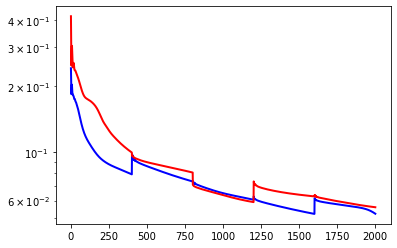

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(niters+1),record_sgd[:,0], color='b', linewidth=2)
plt.plot(range(niters+1),record_sgd_anderson[:,0], color='r', linewidth=2)
plt.yscale('log')

In [7]:
anderson_avg = np.mean(record_anderson,axis=1)
anderson_std = np.std(record_anderson,axis=1)
avg = np.mean(record,axis=1)
std = np.std(record,axis=1)

fig = plt.figure()
plt.plot(range(niters+1),avg, color='b', linewidth=2)
plt.fill_between(range(niters+1), avg-std,avg+std,color='b',alpha=.2)
plt.plot(range(niters+1),anderson_avg, color='r', linewidth=2)
plt.fill_between(range(niters+1), anderson_avg-anderson_std,anderson_avg+anderson_std,color='r',alpha=.2)

AADL_avg = np.mean(record_AADL,axis=1)
AADL_std = np.std(record_AADL,axis=1)
plt.plot(range(niters+1),AADL_avg, color='g', linewidth=2)
plt.fill_between(range(niters+1), AADL_avg-AADL_std,AADL_avg+AADL_std,color='g',alpha=.2)


plt.yscale('log')
plt.ylim([0.001, 2])
plt.legend(['default', 'data_driven_acceleration', 'AADL'])
plt.xlabel('number of iteration')
plt.ylabel('loss')
plt.title('2D Burgers Equation')
fig.savefig('file.png', dpi=500)

NameError: name 'record_anderson' is not defined

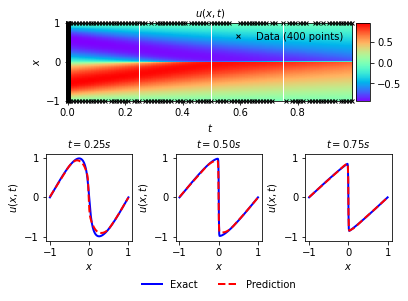

In [ ]:
X_u_train = X_u_train.cpu(); X_u_train = X_u_train.detach().numpy()
u_train = u_train.cpu(); u_train   = u_train.detach().numpy()

 
 
 
solutionplot_burgers(u_pred, X_u_train, u_train, X, T, x, t, usol) # TODO: check input